In [5]:
# импорт библиотек не весь, буду импортировать по ходу исследования
%pip install pandas
import pandas as pd
import os

Note: you may need to restart the kernel to use updated packages.


Загрузка и объединение данных

In [ ]:
# добавляем все датасеты
df_product_info = pd.read_csv("/Users/aleksandrasestakova/Desktop/python/archive-2/product_info.csv")
df_reviews_1 = pd.read_csv("/Users/aleksandrasestakova/Desktop/python/archive-2/reviews_0-250.csv",index_col = 0, dtype={'author_id':'str'})
df_reviews_2 = pd.read_csv("/Users/aleksandrasestakova/Desktop/python/archive-2/reviews_250-500.csv",index_col = 0, dtype={'author_id':'str'})
df_reviews_3 = pd.read_csv("/Users/aleksandrasestakova/Desktop/python/archive-2/reviews_500-750.csv",index_col = 0, dtype={'author_id':'str'})
df_reviews_4 = pd.read_csv("/Users/aleksandrasestakova/Desktop/python/archive-2/reviews_750-1250.csv",index_col = 0, dtype={'author_id':'str'})
df_reviews_5 = pd.read_csv("/Users/aleksandrasestakova/Desktop/python/archive-2/reviews_1250-end.csv",index_col = 0, dtype={'author_id':'str'})

In [45]:
# собираем все датасеты с отзывами в один большой
df_reviews = pd.concat([df_reviews_1,df_reviews_2,df_reviews_3,df_reviews_4,df_reviews_5],axis=0)
# сокращаем датасет до 10 000 строк
df_reviews = df_reviews.sample(n=10000, random_state=42).reset_index(drop=True)

In [46]:
# удаление повторов и пустых значений
missing_values = df_reviews.isnull().sum()
df = df_reviews.dropna()
duplicates = df.duplicated(subset=['review_text']).sum()
df = df.drop_duplicates()

Предобработка текста

In [50]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
stop_words = set(stopwords.words('english'))
%pip install spacy
nlp = spacy.load("en_core_web_sm")

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1020)>


Note: you may need to restart the kernel to use updated packages.


In [54]:
# предобработка текстов отзывов
def preprocess(review_text):
    review_text = re.sub(r'<.*?>', '', review_text)
    review_text = re.sub(r'[^a-zA-Z\s]', '', review_text)
    doc = nlp(review_text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha and len(token.text) > 2]
    return ' '.join(tokens)

df['clean_text'] = df['review_text'].apply(preprocess)

In [56]:
df['clean_text'].head(10)

0                 bottle product absolutely waste money
2     lately love skin toner come right time keep sk...
15    exfoliate good leave skin look flawless super ...
25    love korean skin care glow recipe fave dollar ...
28    product little month hyperpigmentation thankfu...
32    comboacne prone skin moisturiser perfect balan...
41    rarely acne deal uneven skin want like product...
43    want love product hate sunscreen leave white c...
45    absolutely love face eye patch struggle fine l...
46    get set committed size light texture work perf...
Name: clean_text, dtype: object

Визуализация наиболее частотных слов в отзывах

Note: you may need to restart the kernel to use updated packages.


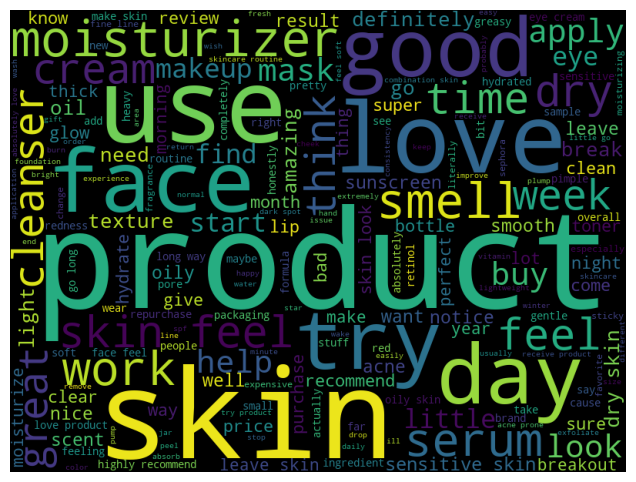

In [57]:
# облако слов
%pip install wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

allwords = ' '.join(word for word in df['clean_text'])
wordcloud = WordCloud(
    width = 800,
    height = 600,
    background_color = 'black').generate(allwords)
plt.figure(figsize=(8,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Классификация по типу продукта

In [58]:
# уникальные значения категории
df_product_info['tertiary_category'].unique()

array(['Perfume Gift Sets', 'Perfume', 'Rollerballs & Travel Size',
       'Body Lotions & Body Oils', nan, 'Cologne', 'Diffusers',
       'Deodorant & Antiperspirant', 'Candles', 'Hair Masks',
       'Leave-In Conditioner', 'Shampoo', 'Hair Oil',
       'Hair Styling Products', 'Scalp Treatments', 'Conditioner',
       'Lip Balm & Treatment', 'Moisturizers', 'Face Serums',
       'Eye Creams & Treatments', 'Face Sunscreen',
       'Face Wash & Cleansers', 'Face Oils', 'Toners', 'Face Masks',
       'Facial Peels', 'Hand Cream & Foot Cream',
       'Decollete & Neck Creams', 'Exfoliators', 'Hair Spray',
       'Hair Primers', 'Tinted Moisturizer', 'Mascara',
       'Setting Spray & Powder', 'Highlighter', 'Concealer', 'Eyebrow',
       'Blush', 'Face Sets', 'Dry Shampoo', 'Curling Irons',
       'Brushes & Combs', 'Hair Straighteners & Flat Irons',
       'Hair Dryers', 'Eyeshadow', 'Lipstick', 'Eye Palettes', 'Contour',
       'Lip Gloss', 'Eye Brushes', 'Foundation', 'False Eyelashes

In [59]:
# подсчёт отзывов в каждой категории
category_stats = df_product_info['tertiary_category'].value_counts().reset_index()
category_stats.columns = ['Product Category', 'Number of Reviews']
print(category_stats)

              Product Category  Number of Reviews
0                      Perfume                568
1                 Moisturizers                386
2                  Face Serums                379
3    Rollerballs & Travel Size                287
4        Hair Styling Products                255
..                         ...                ...
113        Under-Eye Concealer                  3
114                  Sunscreen                  2
115  Hair Thinning & Hair Loss                  2
116               Damaged Hair                  1
117  Manicure & Pedicure Tools                  1

[118 rows x 2 columns]


/var/folders/zg/9j7_c3g93qz83j20jwdk262m0000gn/T/ipykernel_70387/2562720937.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')


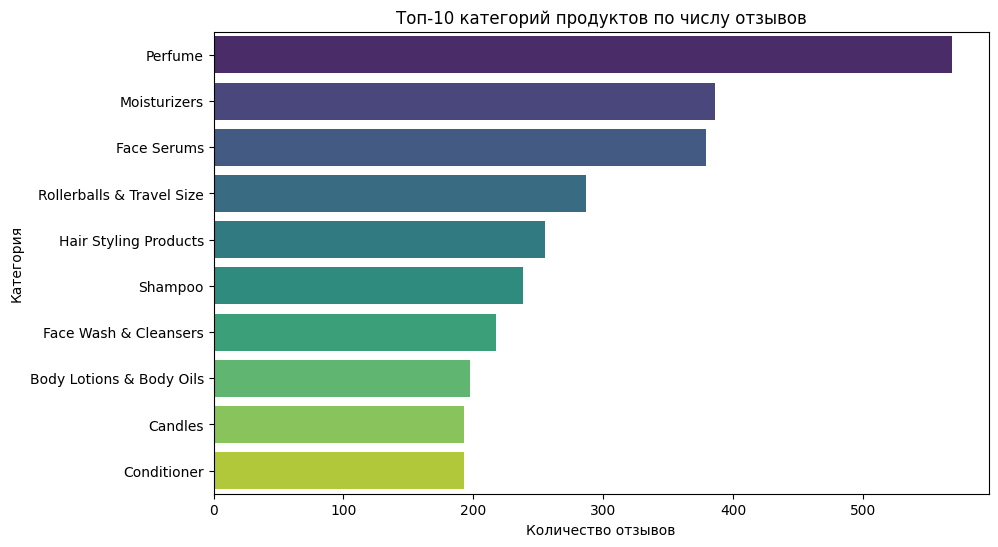

In [60]:
import seaborn as sns

plt.figure(figsize=(10,6))
top_categories = df_product_info['tertiary_category'].value_counts().nlargest(10)
sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
plt.title('Топ-10 категорий продуктов по числу отзывов')
plt.xlabel('Количество отзывов')
plt.ylabel('Категория')
plt.show()

Преобразование рейтинга в тональность

positive - рейтинги 4 и 5

neutral - рейтинг 3

negative - рейтинг 1 и 2

In [61]:
def get_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['rating'].apply(get_sentiment)

Векторизация текста

In [62]:
%pip install scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['clean_text'])
y = df['sentiment']

Note: you may need to restart the kernel to use updated packages.


Деление данных на обучение и тест

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, df['sentiment'], test_size=0.2, random_state=42)

Обучение моделей и оценка

In [64]:
# модель логистическая регрессия

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

model = LogisticRegression()
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [65]:
y_pred = model.predict(X_test)

Classification Report
              precision    recall  f1-score   support

    negative       0.81      0.26      0.40        95
     neutral       0.00      0.00      0.00        56
    positive       0.76      0.99      0.86       390

    accuracy                           0.76       541
   macro avg       0.52      0.42      0.42       541
weighted avg       0.69      0.76      0.69       541



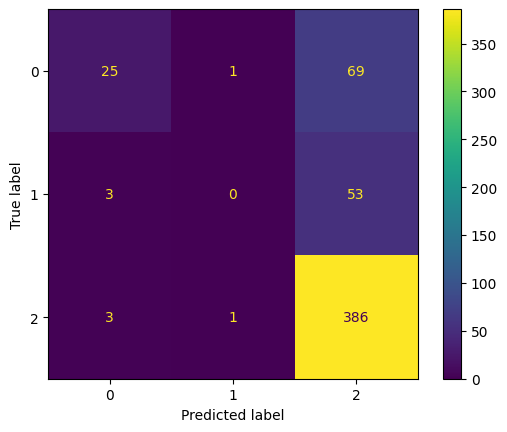

In [66]:
def evaluation_parametrics(name, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    t1 = ConfusionMatrixDisplay(cm)
    print("Classification Report")
    print(classification_report(y_test, y_pred))
    t1.plot()
evaluation_parametrics("Machine Learning - Classification", y_test, y_pred)

In [67]:
# Naive Bayes

from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [68]:
y_pred = model.predict(X_test)

Classification Report
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        95
     neutral       0.00      0.00      0.00        56
    positive       0.72      1.00      0.84       390

    accuracy                           0.72       541
   macro avg       0.24      0.33      0.28       541
weighted avg       0.52      0.72      0.60       541



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

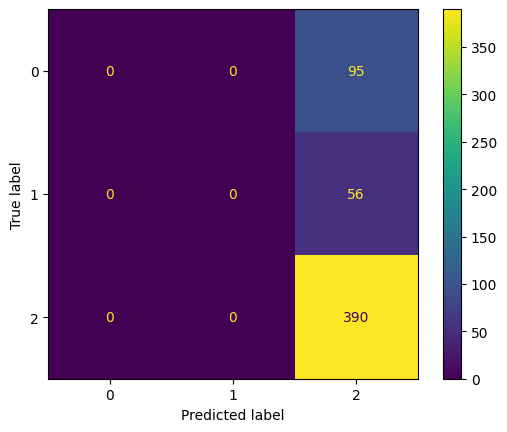

In [69]:
def evaluation_parametrics(name, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    t1 = ConfusionMatrixDisplay(cm)
    print('Classification Report')
    print(classification_report(y_test, y_pred))
    t1.plot()
evaluation_parametrics("Machine Learning Classification", y_test, y_pred)

In [70]:
# модель random forest

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [71]:
y_pred = model.predict(X_test)

Classification Report for Random Forest Classifier: 

              precision    recall  f1-score   support

    negative       0.80      0.25      0.38        95
     neutral       0.00      0.00      0.00        56
    positive       0.76      1.00      0.86       390

    accuracy                           0.76       541
   macro avg       0.52      0.42      0.42       541
weighted avg       0.69      0.76      0.69       541



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

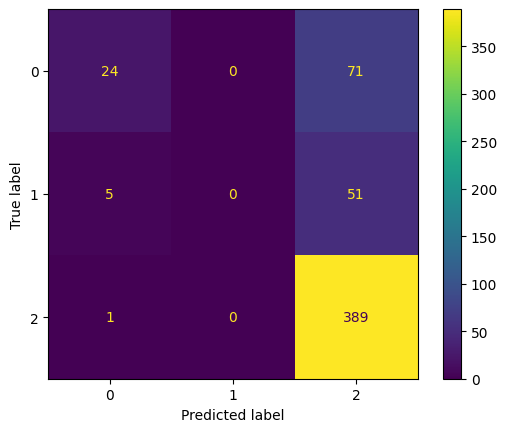

In [72]:
def evaluation_parametrics(name, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    t1 = ConfusionMatrixDisplay(cm)
    print("Classification Report for Random Forest Classifier: \n")
    print(classification_report(y_test, y_pred))
    t1.plot()
evaluation_parametrics('Machine Learning Classification', y_test, y_pred)

In [73]:
# linear SVC

from sklearn.svm import LinearSVC

model = LinearSVC()
model.fit(X_train, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


In [74]:
y_pred = model.predict(X_test)

Classification Report for LinearSVC: 

              precision    recall  f1-score   support

    negative       0.58      0.53      0.55        95
     neutral       0.36      0.07      0.12        56
    positive       0.83      0.95      0.88       390

    accuracy                           0.78       541
   macro avg       0.59      0.51      0.52       541
weighted avg       0.74      0.78      0.75       541



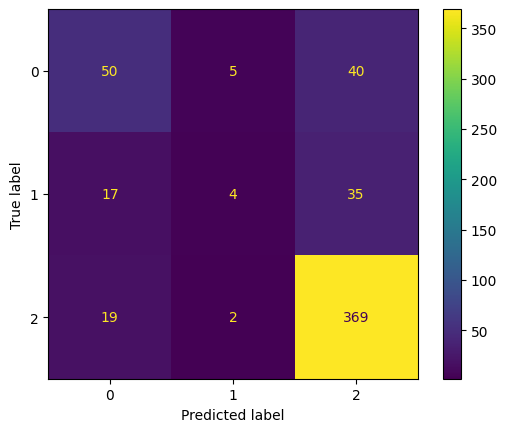

In [75]:
def evaluation_parametrics(name, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    t1 = ConfusionMatrixDisplay(cm)
    print("Classification Report for LinearSVC: \n")
    print(classification_report(y_test, y_pred))
    t1.plot()
evaluation_parametrics('Machine Learning Classification', y_test, y_pred)

Распределение отзывов по тональности

/var/folders/zg/9j7_c3g93qz83j20jwdk262m0000gn/T/ipykernel_70387/1770029729.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='coolwarm')


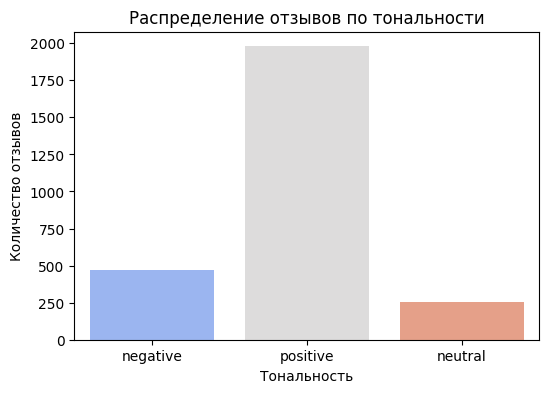

In [76]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment', palette='coolwarm')
plt.title('Распределение отзывов по тональности')
plt.xlabel('Тональность')
plt.ylabel('Количество отзывов')
plt.show()

In [77]:
from sklearn.metrics import precision_score, recall_score, f1_score

models = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Linear SVC': LinearSVC()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    results.append({'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-score': f1})

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='F1-score', ascending=False)
print(results_df)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


                 Model  Accuracy  Precision    Recall  F1-score
3           Linear SVC  0.781885   0.738850  0.781885  0.747284
0  Logistic Regression  0.759704   0.689374  0.759704  0.689421
2        Random Forest  0.757856   0.690137  0.757856  0.678973
1          Naive Bayes  0.720887   0.519678  0.720887  0.603966


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


/var/folders/zg/9j7_c3g93qz83j20jwdk262m0000gn/T/ipykernel_70387/3498840357.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1-score', y='Model', data=results_df, palette='viridis')


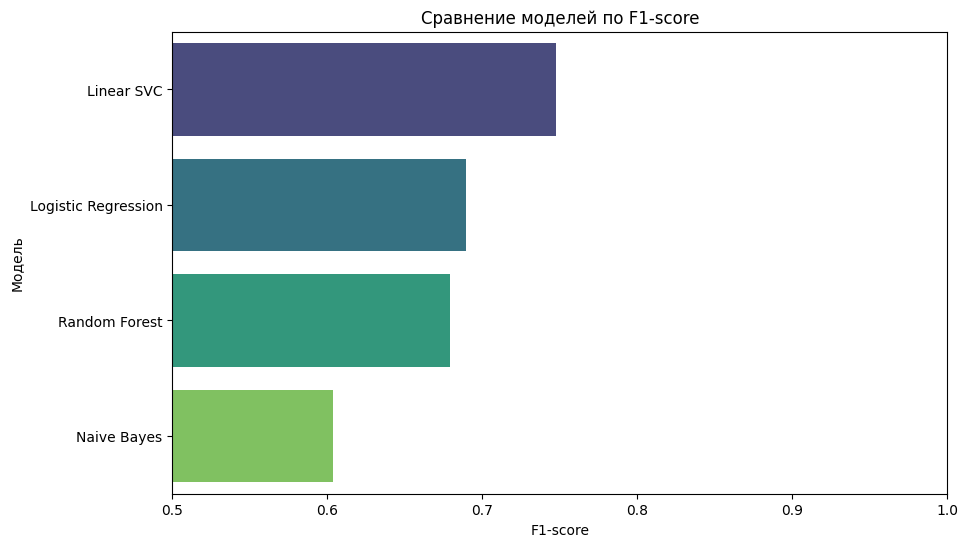

In [78]:
plt.figure(figsize=(10,6))
sns.barplot(x='F1-score', y='Model', data=results_df, palette='viridis')
plt.title('Сравнение моделей по F1-score')
plt.xlabel('F1-score')
plt.ylabel('Модель')
plt.xlim(0.5, 1)
plt.show()